In [1]:
import numpy as np
import pathlib
import random
import torch
import cv2
import optimization_library as optlib

import matplotlib.pyplot as plt
import random
import functools


torch.set_printoptions(precision=3, sci_mode=False)

random.seed(0)
np.random.seed(1)
torch.manual_seed(0)

base_dir = pathlib.Path.cwd()
dlc_model_path = base_dir/"HorseInferenceFiles/DLC_Model_With_Head"
training_data_directory = base_dir / "HorseInferenceFiles"
generated_directory = base_dir/"generated"
urdf_path = base_dir/"horse_like_robot.model.urdf"
device = optlib.getTorchDevice()
print(f"Training with device: {device}")
robot_data = optlib.RobotData.init_from_urdf_file(urdf_path, device=device)

/Users/aman2/anaconda3/envs/dlc3/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-25 19:19:47.461462: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/aman2/anaconda3/envs/dlc3/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Training with device: cpu


Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_hip_tran']/actuator[@name='FR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_thigh_tran']/actuator[@name='FR_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FR_calf_tran']/actuator[@name='FR_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_hip_tran']/actuator[@name='FL_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_thigh_tran']/actuator[@name='FL_thigh_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='FL_calf_tran']/actuator[@name='FL_calf_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_hip_tran']/actuator[@name='RR_hip_motor']
Unknown tag "hardwareInterface" in /robot[@name='a1']/transmission[@name='RR_thigh_tran']/actuator[@name='RR_thigh_motor']
Unknown tag "hardwareInterface" 

In [2]:
total_video = optlib.CV2VideoReader((training_data_directory/"trainset/trimmedHorseVideo.mp4"))
total_training_data = optlib.TrainingKeypoints.init_from_video_using_dlc_model(total_video, dlc_model_path)
first_five_frames_data = total_training_data.get_subset(range(5))


2024-01-25 19:20:14.328966: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-25 19:20:14.503192: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled


In [3]:
robot_data.print_skeleton()

base
  trunk
    FR_hip
      FR_thigh
        FR_calf
          FR_foot
    FL_hip
      FL_thigh
        FL_calf
          FL_foot
    RR_hip
      RR_thigh
        RR_calf
          RR_foot
    Lower Spine
      Tail
    Upper Spine
      Ears
        Nose
          Jawline
    RL_hip
      RL_thigh
        RL_calf
          RL_foot


In [4]:
#Basically we define points on the robot in terms of the link that starts at the joint, and the image is defined in terms of the joint at the position
#For example, a knee on the robot is called a calf since the calf starts at the knee joint, and a knee in the image
robot_image_mapping = {
 'trunk' : None,
 'imu_link' : None,
 'FR_hip' : None,
 'FR_thigh': "Shoulder",
 'FR_calf': "Front Right Knee",
 'FR_foot': "Front Right Ankle",
 'FL_hip': None,
 'FL_thigh': "Shoulder",
 'FL_calf': "Front Left Knee",
 'FL_foot': "Front Left Ankle",
 'RR_hip': None,
 'RR_thigh': "Hip",
 'RR_calf': "Back Right Knee",
 'RR_foot': "Back Right Ankle",
 'RL_hip': None,
 'RL_thigh': "Hip",
 'RL_calf': "Back Left Knee",
 'RL_foot' : "Back Left Ankle",
 'Lower Spine': "End of Tail",
 'Tail': "Tip of Tail",
 'Upper Spine': "End of Neck",
 'Ears': "Ears",
 'Nose': "Nose",
 'Jawline': "Jaw",
}

#Removed all None entries
robot_image_mapping = {key:robot_image_mapping[key] for key in robot_image_mapping if robot_image_mapping[key] is not None}

robot_joints_in_order = list(robot_image_mapping.keys())
image_keypoint_orders = [robot_image_mapping[j] for j in robot_joints_in_order]

These are aligned lists, so that we can start putting them in tensors and the alignment will be implicit once they're in tensors.

## Training Loop

In [5]:
trainingFrames = []
draw_on_image = None

In [6]:
class TrainingVariables():
    def __init__(self,*, joint_angles, fx, fy, u0, v0, tx, ty, tz, extrinsicRotationQuaternion):
        self.joint_angles = joint_angles
        self.fx = fx
        self.fy = fy
        self.u0 = u0
        self.v0 = v0
        self.tx = tx
        self.ty = ty
        self.tz = tz
        self.extrinsicRotationQuaternion = extrinsicRotationQuaternion
    @classmethod
    def initialize_from_initials(cls, *,frame_count: int, joint_angles: "(n.joints,)", fx: float, fy: float, u0: float, v0: float, tx: float, ty: float, tz: float, extrinsicRotationQuaternion:"(4) tensor"):
        """Starting from initial values, intializes the object repeating values as needed"""
        joint_angles = joint_angles.repeat(frame_count,1).requires_grad_(True)

        differentiableConstantTensor = lambda constant: torch.tensor(float(constant), requires_grad=True)
        
        fx = differentiableConstantTensor(fx)
        fy  = differentiableConstantTensor(fy)
        u0 = differentiableConstantTensor(u0)
        v0 = differentiableConstantTensor(v0)



        tx = torch.ones((frame_count,))*tx
        tx = tx.requires_grad_(True)
        ty = torch.ones((frame_count,))*ty
        ty = ty.requires_grad_(True)
        tz = torch.ones((frame_count,))*tz
        tz = tz.requires_grad_(True)

        #Zero rotation quaternion
        #Good visualization resource: https://quaternions.online
        #JS Script to get as tensor (paste into console): 
        # xPathResults = document.evaluate('//*[@id="container"]/div[2]/table[1]//*[contains(@class, "quaternionInput")]',document,null,XPathResult.ORDERED_NODE_SNAPSHOT_TYPE,null); console.log(`torch.tensor([${Array.from(Array(4).keys()).map(i => xPathResults.snapshotItem(i).value).join(",")}])`);
        extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(False).unsqueeze(0) * torch.ones((frame_count,4))
        extrinsicRotationQuaternion = extrinsicRotationQuaternion.requires_grad_(True)
        return cls(joint_angles=joint_angles, fx=fx, fy=fy, u0=u0, v0=v0, tx=tx, ty=ty, tz=tz, extrinsicRotationQuaternion=extrinsicRotationQuaternion)
    def get_as_initials(self):
        """Returns the object in a form that can be splatted into intialize_from_initials. Multi-frame variables only have the first frame value preserved"""
        joint_angles = self.joint_angles[0].detach().clone()
        tx = self.tx[0]
        ty = self.ty[0]
        tz = self.tz[0]
        extrinsicRotationQuaternion = self.extrinsicRotationQuaternion[0].detach().clone()
        return{
            "joint_angles": joint_angles,
            "fx": float(self.fx),
            "fy": float(self.fy),
            "u0": float(self.u0),
            "v0": float(self.v0),
            "tx": float(tx),
            "ty": float(ty),
            "tz": float(tz),
            "extrinsicRotationQuaternion": extrinsicRotationQuaternion
        }



In [7]:
%matplotlib inline
VERBOSE = True
total_epochs = -1
def train(*,training_variables, training_data: optlib.TrainingKeypoints,robot_data: optlib.RobotData, epochs:int, epoch_to_visualize: int = 500, training_mode = "All"):
    global draw_on_image
    global trainingFrames
    global total_epochs
    total_epochs = total_epochs + 1
    joint_angles = training_variables.joint_angles
    fx = training_variables.fx
    fy = training_variables.fy
    u0 = training_variables.u0
    v0 = training_variables.v0
    tx = training_variables.tx
    ty = training_variables.ty
    tz = training_variables.tz
    extrinsicRotationQuaternion = training_variables.extrinsicRotationQuaternion
    learnable_robot_model = robot_data.robot_model
    imgCount = training_data.get_frame_count()
    TRAINING_MODES = {
    "All": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-2),
    "Just Robot": torch.optim.Adam([joint_angles]+ list(learnable_robot_model.parameters()), lr=1e-3),
    "All -Lengths": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion, joint_angles], lr=1e-2),
    "Camera Properties": torch.optim.Adam([fx,fy,u0,v0,tx,ty,tz,extrinsicRotationQuaternion], lr=1e-3),
    }
    optimizer = TRAINING_MODES[training_mode if training_mode in TRAINING_MODES else None]
    optimizer.zero_grad()

    constantTensor = optlib.constantTensor
    intrinsic = torch.vstack([
        torch.hstack([fx,constantTensor(0), u0]),
        torch.hstack([constantTensor(0),fy, v0]),
        torch.hstack([constantTensor(0),constantTensor(0), constantTensor(1)])
    ])

    formatTensor = torch.tensor([1.0,0.0,0.0])
    xComponent = tx.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,1.0,0.0])
    yComponent = ty.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))
    formatTensor = torch.tensor([0.0,0.0,1.0])
    zComponent = tz.reshape((-1,*((1,)*(len(formatTensor.shape)))))*(formatTensor.unsqueeze(0))

    extriniscTransformation = xComponent + yComponent + zComponent
    extrinsicRotation = optlib.pytorch3d.transforms.quaternion_to_matrix(extrinsicRotationQuaternion)
    extriniscTransformation = extriniscTransformation.reshape(imgCount,3,1)
    extrinsic = torch.cat((extrinsicRotation, extriniscTransformation),2)
    
    
    #Get Robot Projection
    robotEEPositions = learnable_robot_model.compute_forward_kinematics_all_links(joint_angles)
    #Prune Rotation Information 
    robotEEPositions = {linkName: robotEEPositions[linkName][0] for linkName in robotEEPositions}
    #If Only One Entry Duplicate Data
    for jointName in robotEEPositions:
        if robotEEPositions[jointName].shape[0] != imgCount:
            robotEEPositions[jointName] = robotEEPositions[jointName].repeat(imgCount,1)
    jointPosition = torch.hstack([robotEEPositions[joint].unsqueeze(1) for joint in robot_joints_in_order])
    jointCameraPositions = optlib.calculateCameraProjection(intrinsic, extrinsic, jointPosition)
    pixelLoss = torch.sum(torch.sqrt(torch.sum(torch.pow(jointCameraPositions.reshape(-1,2) - ((training_data.keypoints).reshape(-1,2)), 2),-1)))
           


    loss = pixelLoss + 10*optlib.losses.totalLimbLength(robot_data, relu=False,reluThreshold = 1) + optlib.losses.interframeJointLoss(joint_angles) #+ optlib.losses.out_of_frame_loss(intrinsic,extrinsic, total_video, robotEEPositions, scalar = 100)
    draw_on_image = functools.partial(optlib.drawPredictionOnImage, intrinsic=intrinsic, extrinsic=extrinsic, robotEEPositions=robotEEPositions, training_dataset = training_data, robot_data=robot_data)
    if total_epochs % 100 == 0 and VERBOSE:
        #Print every n epoch's including the 0th one
        print(f"Epoch {total_epochs}: Loss ({loss}), Loss Per Entry ({loss/jointCameraPositions.reshape(-1,2).shape[0]} pixels)")
    trainingFrames.append(draw_on_image(image_index=0))
    n = 500
    if total_epochs % epoch_to_visualize == 0 and VERBOSE:        
        plt.clf()
        plt.imshow(draw_on_image(image_index=0))
        plt.show()
    loss.backward()
    optimizer.step()

In [8]:
trainingFrames = []
robot_data.make_limb_length_learnable()
init_angles = torch.zeros((1,len(robot_data.get_link_names())))
training_data = first_five_frames_data.reordered_training_set(image_keypoint_orders)
training_variables = TrainingVariables.initialize_from_initials(frame_count = training_data.get_frame_count(), joint_angles=init_angles, fx=-320, fy=320, u0=320, v0=160, tx=0, ty=0, tz=1, 
                                                                extrinsicRotationQuaternion=torch.tensor([0.55,0.3,0.1,-0.1])
)
learnable_robot_model = robot_data.robot_model

Epoch 0: Loss (7153.65234375), Loss Per Entry (79.48502349853516 pixels)


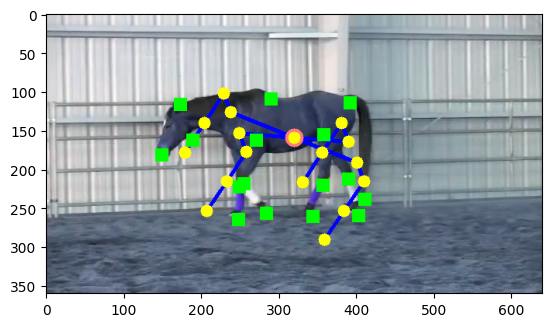

Epoch 100: Loss (5764.2919921875), Loss Per Entry (64.04769134521484 pixels)
Epoch 200: Loss (5299.2177734375), Loss Per Entry (58.88019561767578 pixels)
Epoch 300: Loss (5291.4482421875), Loss Per Entry (58.79386901855469 pixels)
Epoch 400: Loss (5289.82421875), Loss Per Entry (58.77582550048828 pixels)
Epoch 500: Loss (5287.7001953125), Loss Per Entry (58.75222396850586 pixels)


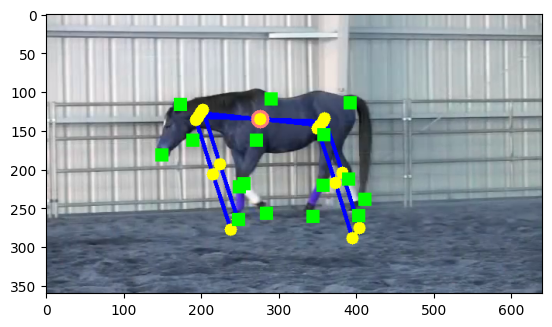

Epoch 600: Loss (5286.8671875), Loss Per Entry (58.74296951293945 pixels)
Epoch 700: Loss (5285.81689453125), Loss Per Entry (58.731300354003906 pixels)
Epoch 800: Loss (5285.0048828125), Loss Per Entry (58.72227478027344 pixels)
Epoch 900: Loss (5284.18994140625), Loss Per Entry (58.71322250366211 pixels)
Finished stage 1
Epoch 1000: Loss (5281.4296875), Loss Per Entry (58.682552337646484 pixels)


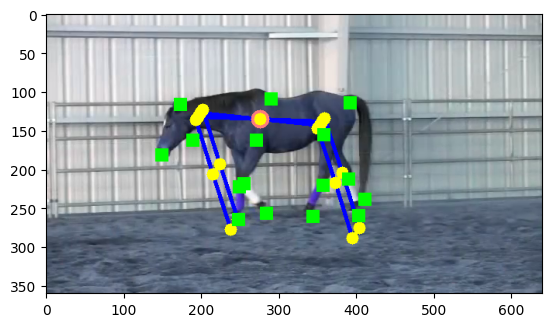

Epoch 1100: Loss (1793.8636474609375), Loss Per Entry (19.93181800842285 pixels)
Epoch 1200: Loss (1291.4007568359375), Loss Per Entry (14.348896980285645 pixels)
Epoch 1300: Loss (1195.8358154296875), Loss Per Entry (13.287064552307129 pixels)
Epoch 1400: Loss (1122.5068359375), Loss Per Entry (12.472298622131348 pixels)
Epoch 1500: Loss (1052.93994140625), Loss Per Entry (11.699332237243652 pixels)


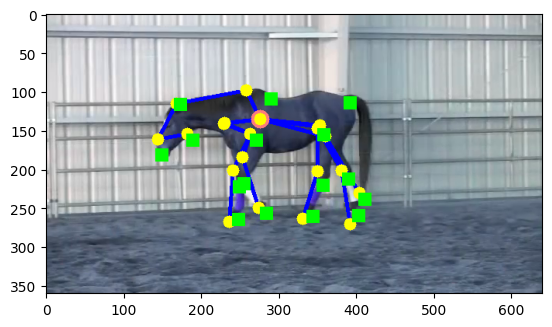

Epoch 1600: Loss (947.5883178710938), Loss Per Entry (10.528759002685547 pixels)
Epoch 1700: Loss (908.2706298828125), Loss Per Entry (10.091896057128906 pixels)
Epoch 1800: Loss (880.734619140625), Loss Per Entry (9.785940170288086 pixels)
Epoch 1900: Loss (853.4600219726562), Loss Per Entry (9.482889175415039 pixels)
Finished stage 2
Epoch 2000: Loss (550497.75), Loss Per Entry (26.22916603088379 pixels)


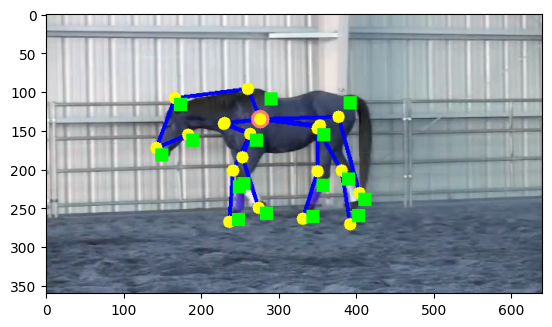

Epoch 2100: Loss (307639.21875), Loss Per Entry (14.657862663269043 pixels)
Epoch 2200: Loss (258087.578125), Loss Per Entry (12.296911239624023 pixels)
Epoch 2300: Loss (239784.40625), Loss Per Entry (11.424833297729492 pixels)
Epoch 2400: Loss (233484.9375), Loss Per Entry (11.124687194824219 pixels)
Epoch 2500: Loss (229794.21875), Loss Per Entry (10.948838233947754 pixels)


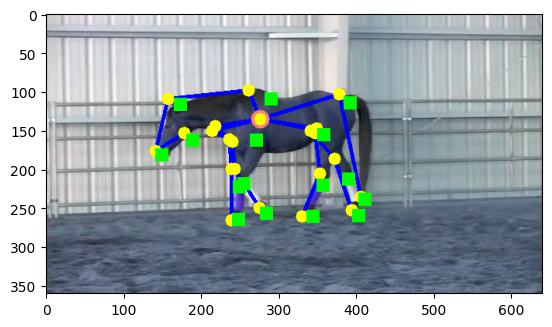

Epoch 2600: Loss (227186.921875), Loss Per Entry (10.824610710144043 pixels)
Epoch 2700: Loss (225794.21875), Loss Per Entry (10.75825309753418 pixels)
Epoch 2800: Loss (225254.6875), Loss Per Entry (10.73254680633545 pixels)
Epoch 2900: Loss (225127.6875), Loss Per Entry (10.726495742797852 pixels)
Finished all training


In [9]:
#
total_epochs = -1
for epoch in range(1000):
    train(epochs = 3000, training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode="Camera Properties")
print("Finished stage 1")
training_variables = training_variables.initialize_from_initials(**training_variables.get_as_initials(), frame_count=training_data.get_frame_count())
for epoch in range(1000):
    train(epochs = 3000, training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode = "Just Robot")
print("Finished stage 2")
training_data = total_training_data.reordered_training_set(image_keypoint_orders)
training_variables = training_variables.initialize_from_initials(**training_variables.get_as_initials(), frame_count=training_data.get_frame_count())
for epoch in range(1000):
    train(epochs = 2000, training_variables=training_variables, training_data = training_data, robot_data = robot_data, training_mode = "Just Robot")
print("Finished all training")

In [10]:
training_variables.joint_angles.shape

torch.Size([1166, 24])

In [11]:
#Index (In joint_angles) to joint_name
index_to_robot_joint = {i:e for i,e in enumerate(robot_data.get_link_names())}
#Convert into json of joint: its angle by frame in degrees
joint_angle_by_frame = {joint_name:(training_variables.joint_angles.T[index]*(torch.pi/180)).tolist() for index, joint_name in index_to_robot_joint.items()}
#Written to join_angles.json for use by simulator
import json
with open(generated_directory/"joint_angles.json", 'w') as json_file:
    json.dump(json.dumps(joint_angle_by_frame), json_file, indent=4)

In [12]:
if not generated_directory.exists():
    generated_directory.mkdir(parents=True)

In [13]:
#Export video of training
vidOut = cv2.VideoWriter(str(generated_directory/'training_video.mp4'),cv2.VideoWriter_fourcc(*'mp4v'), 1, (640,360))
for frame in trainingFrames:
    vidOut.write(frame)
vidOut.release()

In [14]:
#Export video of the frames
vidOut = cv2.VideoWriter(str(generated_directory/'final_video_horse_based.mp4'),cv2.VideoWriter_fourcc(*'mp4v'), 10, (640,360))
for index in range(training_data.get_frame_count()):
    vidOut.write(draw_on_image(image_index=index))
vidOut.release()

In [15]:
exported_robot_path = str(generated_directory/"generatedURDF.urdf")
robot_data.write_to_urdf_file(exported_robot_path)

ERobot: a1 (by File Import), 18 joints (RRRRRRRRRRRRRRRRRR), 6 branches, dynamics, geometry, collision
┌─────┬─────────────┬───────┬─────────────┬───────────────────────────────────────┐
│link │    link     │ joint │   parent    │          ETS: parent to link          │
├─────┼─────────────┼───────┼─────────────┼───────────────────────────────────────┤
│   0 │ base        │       │ BASE        │ SE3()                                 │
│   1 │ trunk       │       │ base        │ SE3()                                 │
│   2 │ FR_hip      │     0 │ trunk       │ SE3(0.1545, 0.021, -0.054) ⊕ Rx(q0)   │
│   3 │ FR_thigh    │     1 │ FR_hip      │ SE3(-0.026, -0.1518, -0.06) ⊕ Ry(q1)  │
│   4 │ FR_calf     │     2 │ FR_thigh    │ SE3(0.02, -0.04, -0.124) ⊕ Ry(q2)     │
│   5 │ @FR_foot    │       │ FR_calf     │ SE3(0, 0, -0.2)                       │
│   6 │ FL_hip      │     3 │ trunk       │ SE3(0.1425, 0.009, -0.038) ⊕ Rx(q3)   │
│   7 │ FL_thigh    │     4 │ FL_hip      │ SE3(-0.038, 0

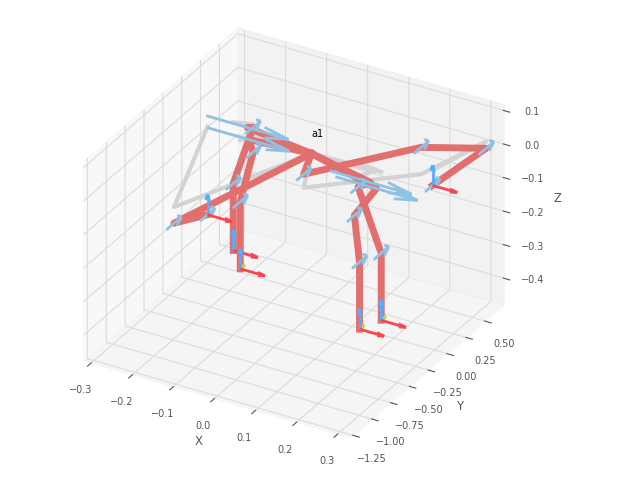

PyPlot3D backend, t = 0.05, scene:
  robot: Text(0.0, 0.0, 'a1')

In [18]:
import numpy as np
from roboticstoolbox.robot.ERobot import ERobot
from math import pi
import pathlib

base_dir = pathlib.Path.cwd()
generated_directory = base_dir/"generated"

class RobotXML(ERobot):

    def __init__(self):

        links, name, urdf_string, urdf_filepath = self.URDF_read(
            exported_robot_path
        )

        super().__init__(
            links,
            name=name,
            urdf_string=urdf_string,
            urdf_filepath=urdf_filepath,
        )

        self.manufacturer = "File Import"


robot = RobotXML()
print(robot)

%matplotlib widget
robot.plot(np.zeros(robot.n), backend="pyplot")